##### This Notebook will take a single HDF file and plot region of interest (eg. Lucknow) via GeoDataFrame
##### Advantage over BaseMap: 
- You will have all lat/long values of the ROI with corresponding AOD values
- The same GeoDataFrame can be used to append more information like windspeed etc

##### Files Required
- A HDF file corresponsing to 1 day of any region. eg. In the code below, the region is represented by h25v06
- A Lat/Long file corresponding to region eg. h25v06 is used below
- Shape file corresponding to a region in the tile. Note that here the shapefile is composed of multiple point geometries representing lat/long of lucknow region. These latlong are as they appear in the tile. The shapefile can be made in QGIS by clipping the Tile with the shapefile (polygon) of lucknow


In [1]:
#initializations (some may not be necessary)
from pyhdf import SD
import numpy as np
from collections import OrderedDict
import numpy.ma as ma
import pyproj
from mpl_toolkits.basemap import Basemap, cm
import matplotlib.pyplot as plt
import sys
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import requests
import os

In [2]:
%matplotlib inline
#loops through all files listed in the text file
FILENAME = "MCD19A2.A2019304.h25v06.006.2019306052717.hdf"

#user_input=input('\nWould you like to process\n' + FILE_NAME + '\n\n(Y/N)')
#if(user_input == 'N' or user_input == 'n'):
#    continue
#else:

# A HDF file covering the tile corresponnding to northern India
#FILE_NAME = 'MCD19A2.A2019334.h24v06.006.2019336233110.hdf'
#Open the file
hdf=SD.SD("data15Oct-15Nov-2019/"+FILENAME)
#Read the subdatasets
#extract the list of SDS in the hdf4 file
datasets=hdf.datasets()
#Print the list
for i,v in enumerate(datasets):
    print('{0}. {1}'.format(i+1,v))

# The Corresponding Lat/Long of the file
FILE_NAME2 = 'MAIACLatlon.h25v06.hdf'
#Open the file
hdf2=SD.SD(FILE_NAME2)
#Read the subdatasets
#extract the list of SDS in the hdf4 file
datasets2=hdf2.datasets()
#Print the list
for i,v in enumerate(datasets2):
    print('{0}. {1}'.format(i+1,v))
#Variables for lat/long necessary to plot the AOD
#Source: https://portal.nccs.nasa.gov/datashare/maiac/DataRelease/MODISTile_lat-lon/
# Get lat and lon info
lat = hdf2.select('lat')
latitude = lat[:,:]
min_lat=latitude.min()
max_lat=latitude.max()
lon = hdf2.select('lon')
longitude = lon[:,:]
min_lon=longitude.min()
max_lon=longitude.max()

#get SDS, (choose from the list of SDS)
SDS_NAME = 'Optical_Depth_047'
sds=hdf.select(SDS_NAME)
attributes=sds.attributes()
scale_factor=attributes['scale_factor']

#get valid range for AOD SDS
range=sds.getrange()
min_range=min(range)
max_range=max(range)
#get SDS data
data=sds.get()
#get data within valid range
valid_data=data.ravel()
valid_data=[x for x in valid_data if x>=min_range]
valid_data=[x for x in valid_data if x<=max_range]
valid_data=np.asarray(valid_data)
#scale the valid data
valid_data=valid_data*scale_factor
#find the average
average=sum(valid_data)/len(valid_data)
#find the standard deviation
stdev=np.std(valid_data)
#print information
print('\nThe valid range of values is: ',round(min_range*scale_factor,3), ' to ',round(max_range*scale_factor,3),'\nThe average is: ',round(average,3),'\nThe standard deviation is: ',round(stdev,3))
print('The range of latitude in this file is: ',min_lat,' to ',max_lat, 'degrees \nThe range of longitude in this file is: ',min_lon, ' to ',max_lon,' degrees')

#Filter the AOD values
attrs = sds.attributes(full=1)
fillvalue=attrs['_FillValue']
# fillvalue[0] is the attribute value (-9999)
fv = fillvalue[0]
#turn fillvalues to NaN
data=data.astype(float)
data[data == fv] = np.nan





1. Optical_Depth_047
2. Optical_Depth_055
3. AOD_Uncertainty
4. FineModeFraction
5. Column_WV
6. AOD_QA
7. AOD_MODEL
8. Injection_Height
9. cosSZA
10. cosVZA
11. RelAZ
12. Scattering_Angle
13. Glint_Angle
1. lat
2. lon

The valid range of values is:  -0.1  to  5.0 
The average is:  1.425 
The standard deviation is:  1.217
The range of latitude in this file is:  20.004168  to  29.995832 degrees 
The range of longitude in this file is:  74.49885  to  92.367355  degrees


In [3]:
#create a dataframe consisting of latitude, longitude and AOD

long = []
lat = []
aod = []
for row in np.arange(len(longitude)):
    for col in np.arange(len(longitude)):
        long.append(longitude[row][col])
        lat.append(latitude[row][col])
        aod.append((data[2][row][col])*scale_factor)

        
tileDF = pd.DataFrame({'latitude': lat, 'longitude': long, 'aod': aod})


In [ ]:
#you can choose to have a column of Point geometry or just avoid it
#geometry = [Point(xy) for xy in zip(tileDF['latitude'], tileDF['longitude'])]
#df['geometry'] = geometry

In [4]:
#dave the DataFrame as a csv for future use
tileDF.to_csv('NorthEast-tile.csv')

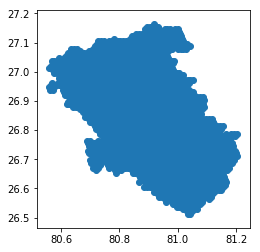

In [5]:
#load the clipped shapefile of Lucknow which consists of lat-long-aod values
#clipping = intersection of lucknowshapefile and NorthEasT Tile Latlong = LucknowShape with LatLong. Made using QGIS (Should be possible programtically)


fp = r"Lucknow-withLatLong\Lucknow-withLatLong.shp"
# Read file using gpd.read_file()
lucknowShape = gpd.read_file(fp)
lucknowShape.plot()

In [6]:
#Filter the AOD values such that AOD values of type '--' are removed
lucknowShape = lucknowShape[lucknowShape.aod != '--']
#convert AOD string to AOD float
lucknowShape['aod'] = lucknowShape['aod'].astype(float)

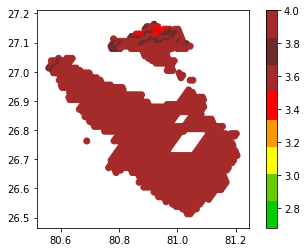

In [7]:
#this creates a custom colormap. Custom color map is good to have, choice of colors and division is yours
#Obviosuly, the choice of scheme is yours. 
import matplotlib.colors as cl
my_cmap = cl.ListedColormap(['#00cc00', '#66cc00', '#ffff00', '#ff9900', '#ff0000', '#a52a2a', '#6e2a2a', '#a52a2a'])
#boundaries = [1,2,3,4,2.50,3,3.50,4] #Upper ceiling
boundaries = np.linspace(1,4,10)
norm = cl.BoundaryNorm(boundaries, my_cmap.N, clip=True)
ax=lucknowShape.plot(column="aod",cmap=my_cmap, norm=norm, linewidth=1, legend=True);

In [8]:
# this dataframe can be used to append more information on Lucknow, like windspeed, temperature etc
lucknowShape.head()

,field_1,latitude,longitude,aod,geometry
0,408239,27.162500,80.920074,3.488,(POINT (80.92007446289063 27.16250038146973))
1,409437,27.154167,80.895309,3.342,(POINT (80.89530944824219 27.15416717529297))
2,409438,27.154167,80.904671,3.332,(POINT (80.90467071533203 27.15416717529297))
3,409439,27.154167,80.914040,3.136,(POINT (80.91403961181641 27.15416717529297))
4,409440,27.154167,80.923401,3.130,(POINT (80.92340087890625 27.15416717529297))
